In [577]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import corner
from scipy.stats import binom
import emcee
import scipy.stats as st

In [838]:
a = np.ones((10,30))
np.prod(np.shape(a))

300

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
CONST = 1e-6

In [372]:
class MyDataset(Dataset):
    def __init__(self, number):
        self.make_data(number)
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return [self.data[index: index+1][0][0],self.data[index: index+1][0][1]]

    def make_data(self,number=int(1e3)):

        dataset = np.array([self.gen_sin() for i in range(number)])

        self.data = np.array(dataset)

    def gen_sin(self):
        xs = np.linspace(0,1.1,100)
        self.xs = xs
        phs = np.random.rand(1)[0]                                                                                                                 
        amp = np.random.rand(1)[0]
        ys = self.sin_model(xs, phs, amp) + (np.random.rand(len(xs)) - 0.5)*0.05
        return ys, np.array([phs, amp])  
    
    def sin_model(self,xs,  phs, amp):
        ys = amp*np.cos(2.*np.pi*(xs + phs))
        return (ys + 1)*0.5
    
    def gen_sin_2mod(self):
        xs = np.linspace(0,1.1,100)
        phs = np.random.rand(1)[0]                                                                                                                   
        amp = (np.random.rand(1)[0] - 0.5)*2
        ys = amp*np.cos(2.*np.pi*xs + phs*2*np.pi) + (np.random.rand(len(xs)) - 0.5)*0.05
        return (ys + 1)*0.5, np.array([phs, amp])

    def gen_line(self):
        xs = np.linspace(0,1.1,100)
        slope= np.random.rand(1)
        off = np.random.rand(1)
        ys = slope*xs + np.random.rand(len(xs))*0.03 + off
        return ys, np.array([slope[0], off[0]])

In [807]:
class VAE(nn.Module):

    def __init__(self, input_dim, par_dim, hidden_dim, latent_dim, device, num_hidden=2):
        """                                                                                                                                           
        args                                                                                                                                          
        ----------                                                                                                                                    
        input_dim: int                                                                                                                                
            length of input time series                                                                                                               
        hidden_dim: int                                                                                                                               
            size of hidden layers in all encoders                                                                                                     
        z_dim: int                                                                                                                                    
            number of variables in latent space                                                                                                       
        par_dim: int                                                                                                                                  
            number of parameter to estimate                                                                                                           
                                                                                                                                                      
        """
        super().__init__()
        self.device = device
        self.input_dim = input_dim
        self.par_dim = par_dim
        self.latent_size = latent_dim
        
        self.num_hidden = num_hidden
        self.activation = nn.functional.relu
        
        conv_size = 10
        stride = 10
        
        # encoder r1(z|y)                                                                                                                               
        # input layer
        #self.r_input = nn.Linear(input_dim, hidden_dim)
        self.r_input = torch.nn.Conv1d(1, hidden_dim, conv_size, stride=stride)
        #for i in range(self.num_hidden):
        #    setattr(self,"r_linear{}".format(i),nn.Linear(hidden_dim, hidden_dim))
        #self.r_layers = {"input" : nn.Linear(input_dim, hidden_dim)}
        #for i in range(self.num_hidden):
        #    self.r_layers["linear{}".format(i+1)] = nn.Linear(hidden_dim, hidden_dim)
        # output mean and variance of gaussian with size of latent space                                                                              
        self.mu_r = nn.Linear(hidden_dim*int(input_dim/stride), self.latent_size)
        self.log_var_r = nn.Linear(hidden_dim*int(input_dim/stride), self.latent_size)
        
        # encoder q(z|x, y)    
        #self.q_input = nn.Linear(input_dim+par_dim, hidden_dim)
        self.q_input = torch.nn.Conv1d(1, hidden_dim, conv_size, stride=stride)
        #for i in range(self.num_hidden):
        #    setattr(self,"q_linear{}".format(i),nn.Linear(hidden_dim, hidden_dim))
        #self.q_layers = {"input" : nn.Linear(input_dim+par_dim, hidden_dim)}
        #for i in range(self.num_hidden):
        #    self.q_layers["linear{}".format(i+1)] = nn.Linear(hidden_dim, hidden_dim)
        self.mu_q = nn.Linear(hidden_dim*int((input_dim+par_dim)/stride), self.latent_size)
        self.log_var_q = nn.Linear(hidden_dim*int((input_dim+par_dim)/stride), self.latent_size)

        # decode r2(x|z, y)         
        #self.d_input = nn.Linear(input_dim+self.latent_size, hidden_dim)
        self.d_input = torch.nn.Conv1d(1, hidden_dim, conv_size, stride=stride)
        #for i in range(self.num_hidden):
        #    setattr(self,"d_linear{}".format(i),nn.Linear(hidden_dim, hidden_dim))
        #self.d_layers = {"input" : nn.Linear(input_dim+self.latent_size, hidden_dim)}
        #for i in range(self.num_hidden):
        #    self.d_layers["linear{}".format(i+1)] = nn.Linear(hidden_dim, hidden_dim)
        self.mu_d = nn.Linear(hidden_dim*int((input_dim+latent_dim)/stride), self.par_dim)
        self.log_var_d = nn.Linear(hidden_dim*int((input_dim+latent_dim)/stride), self.par_dim)
        
        
    def encode_r(self,y):
        """ encoder r1(z|y) , takes in observation y"""
        y = torch.reshape(y, (-1, 1, self.input_dim))
        hidden = torch.flatten(self.activation(self.r_input(y)), start_dim = 1)
        #for i in range(self.num_hidden):
        #    hidden = self.activation(getattr(self,"r_linear{}".format(i))(hidden))
        #hidden = nn.functional.relu(self.r_layers["input"](y))
        #for i in range(self.num_hidden):
        #    hidden = nn.functional.relu(self.r_layers["linear{}".format(i+1)](hidden))
        z_mu = self.mu_r(hidden)
        z_log_var = self.log_var_r(hidden)
        return z_mu, z_log_var
    
    def encode_q(self,y,par):
        """ encoder q(z|x, y) , takes in observation y and paramters par (x)"""
        indata = torch.cat([y, par], 1)
        indata = torch.reshape(indata, (-1, 1, self.input_dim+self.par_dim))
        hidden = torch.flatten(self.activation(self.q_input(indata)), start_dim = 1)
        #for i in range(self.num_hidden):
        #    hidden = self.activation(getattr(self,"q_linear{}".format(i))(hidden))
        #hidden = nn.functional.relu(self.q_layers["input"](indata))
        #for i in range(self.num_hidden):
        #    hidden = nn.functional.relu(self.q_layers["linear{}".format(i+1)](hidden))
        z_mu = self.mu_q(hidden)
        z_log_var = self.log_var_q(hidden)
        return z_mu, z_log_var
    
    def decode(self, z, y):
        """ decoder r2(x|z, y) , takes in observation y and latent paramters z"""
        indata = torch.cat((z,y), 1)
        indata = torch.reshape(indata, (-1, 1, self.input_dim+self.latent_size))
        hidden = torch.flatten(self.activation(self.d_input(indata)), start_dim = 1)
        #for i in range(self.num_hidden):
        #    hidden = self.activation(getattr(self,"d_linear{}".format(i))(hidden))
        #hidden = nn.functional.relu(self.d_layers["input"](indata))
        #for i in range(self.num_hidden):
        #    hidden = nn.functional.relu(self.d_layers["linear{}".format(i+1)](hidden))
        par_mu = self.mu_d(hidden)
        par_log_var = self.log_var_d(hidden)
        return par_mu, par_log_var
    
    def sample(self,mu,log_var,num_samples):
        """Sample from Gaussian with mean mu and log variance log_var"""
        # get variance from log variance
        std = torch.exp(0.5 * log_var)
        # draw from normal unit distribution N(0,1) with same size as std
        eps = torch.randn([num_samples,std.size(0)]).to(self.device)
        # multiple normal dist by variance and add mean so samples from N(mu, sigma)
        x_sample = eps * std + mu_q
        
        return x_sample
        
    def log_lik(self,par, mu, log_var):
        # gaussian likelihood
        sigma_square = torch.square(torch.exp(0.5*(log_var)))
        return -0.5*torch.log(2*np.pi*sigma_square) - 0.5*torch.square(par-mu)/sigma_square
    
    def forward(self, y, par):
        """forward pass for training"""
        y = y.view(-1,self.input_dim).float()
        par = par.view(-1,self.par_dim).float()
        
        batch_size = y.size(0) # set the batch size
        mu_r, log_var_r = self.encode_r(y) # encode r1(z|y)
        mu_q, log_var_q = self.encode_q(y, par) # encode q(z|x, y)
        
        # sample z from q(z|x, y)
        std = torch.exp(0.5 * (log_var_q))
        eps = torch.randn([batch_size, self.latent_size]).to(self.device)
        z_sample = eps * std + mu_q
        
        mu_par, log_var_par = self.decode(z_sample,y) # decode r2(x|z, y)                                                                                        
        return mu_par, log_var_par, mu_q, log_var_q, mu_r, log_var_r
    
    def test(self, y, num_samples):
        """forward pass for testing the network """
        y = y.view(-1,self.input_dim).float()
        mu_r, log_var_r = self.encode_r(y) # encode r1(z|y)
        #z_sample = self.sample(mu_r,var_r, num_samples) # sample z from r1(z|y)
        x_samples = []
        for i in range(num_samples):
            std = torch.exp(0.5 * (log_var_r))
            eps = torch.randn([1, self.latent_size]).to(self.device)
            z_sample = eps * std + mu_r

            mu_par, log_var_par = self.decode(z_sample,y) # decode r2(x|z, y) from z
            std = torch.exp(0.5 * (log_var_par))
            eps = torch.randn([1, self.par_dim]).to(self.device)
            samp = eps * std + mu_par
            x_samples.append(samp.numpy())
        return x_samples

In [761]:
def KL(mu_r,log_var_r,mu_q,log_var_q):
    """Gaussian KL divergence"""
    sigma_q = torch.exp(0.5 * (log_var_q))
    sigma_r = torch.exp(0.5 * (log_var_r))
    t1 = torch.square(sigma_q/sigma_r)
    t2 = torch.log(torch.square(sigma_r/sigma_q))
    t3 = torch.square(mu_r - mu_q)/torch.square(sigma_r)
    kl_loss = 0.5*torch.sum(t1 + t2 + t3, dim=1) - 0.5*t1.size(1)
    return kl_loss

In [762]:
def log_lik(par, mu, log_var):
    """Gaussian log-likelihood """ 
    par = par.view(-1,1).float()
    mu = mu.view(-1,1).float()
    log_var = log_var.view(-1,1).float()
    sigma_square = torch.square(torch.exp(0.5*(log_var)))
    return -0.5*torch.sum((torch.log(2*np.pi*sigma_square) + torch.square(par-mu)/sigma_square),dim=1)/par.size(1)

In [763]:
def train_batch(model, optimizer, device, batch, labels):
    model.train()

    optimizer.zero_grad()
    length = float(batch.size(0))
    mu_x, log_var_x, mu_q, log_var_q, mu_r, log_var_r = model(batch,labels)
    # get the loss funtion                                                                                                                            
    kl_loss_b = KL(mu_r,log_var_r,mu_q,log_var_q)
    L_loss_b = log_lik(labels, mu_x, log_var_x)
    L_loss = torch.sum(L_loss_b)
    kl_loss = torch.sum(kl_loss_b)

    loss = -(L_loss - kl_loss)/length
    loss.backward()

    # update the weights                                                                                                                              
    optimizer.step()

    return loss, kl_loss/length, L_loss/length

In [764]:
def train(model, device, epochs, train_iterator, optimizer):

    train_losses = []
    kl_losses = []
    lik_losses = []

    for epoch in range(epochs):
        # Training    
        ep_tr = 0
        ep_kl = 0
        ep_l = 0
        num_batch = 0
        for local_batch, local_labels in train_iterator:
            # Transfer to GPU            
            #print(local_labels)
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            train_loss,kl_loss,lik_loss = train_batch(model, optimizer, device, local_batch,local_labels)
            ep_tr = train_loss
            ep_kl = kl_loss
            ep_l = lik_loss
            num_batch = 1
            del local_batch, local_labels
        train_losses.append(ep_tr/num_batch)
        kl_losses.append(kl_loss/num_batch)
        lik_losses.append(lik_loss/num_batch)
        if epoch % int(epochs/10) == 0:                                                                                                              
            print("Epoch: {}, Training loss: {}, kl_loss: {}, l_loss:{}".format(epoch,train_loss,kl_loss,lik_loss))

    return train_losses, kl_losses, lik_losses

In [765]:
def run(test_it,num_samples = 500):
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0
    samples = {}
    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for local_batch, local_labels in test_it:
            # Transfer to GPU                                                                                                                         
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            samples = model.test(local_batch,num_samples)
            samples = np.transpose(np.array(samples),(1,0,2))               
            truths = local_labels
            break
    return samples,truths.numpy()

In [766]:
def log_likelihood(params,x,y,model):
    phs, amp, sig = params
    if phs < 0.0 or phs > 1.0:
        return -np.inf
    if amp < 0.0 or amp > 1.0:
        return -np.inf
    if sig <= 0 or sig >= 2.:
        return -np.inf
    else:
        N = len(x)
        mu = model(x,phs,amp)
        test = -np.log(sig*np.sqrt(2*np.pi))
        lik_func = np.sum(test - ((y - mu)**2/(2*sig*sig)))
        return lik_func
        #return np.sum(np.log(st.vonmises.pdf(y, sig, loc = mu)))

def test_mcmc(x,y,model,inj):
    
    ndim, nwalkers = 3, 50
    ranges = np.array([[inj[0] - 0.15,0,0],[inj[0] + 0.15,1,1]])
    pos = [ranges[0] + np.random.rand(ndim)*(ranges[1] - ranges[0]) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(x,y,model))
    
    out = sampler.run_mcmc(pos, 2000)
    
    samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))
    
    return samples
    
        

In [767]:
train_data = MyDataset(int(1e4))
train_iterator = DataLoader(train_data, batch_size=1000, shuffle=True)

In [808]:
model = VAE(100,2,16,4,device,num_hidden=1).to(device)

In [809]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

In [810]:
for i in model.parameters():
    print(i.shape)

torch.Size([16, 1, 10])
torch.Size([16])
torch.Size([4, 160])
torch.Size([4])
torch.Size([4, 160])
torch.Size([4])
torch.Size([16, 1, 10])
torch.Size([16])
torch.Size([4, 160])
torch.Size([4])
torch.Size([4, 160])
torch.Size([4])
torch.Size([16, 1, 10])
torch.Size([16])
torch.Size([2, 160])
torch.Size([2])
torch.Size([2, 160])
torch.Size([2])


In [811]:
losses, kl_loss, l_loss = train(model, device, 1000, train_iterator, optimizer)

Epoch: 0, Training loss: 2.5239264965057373, kl_loss: 0.36961326003074646, l_loss:-2.154313325881958
Epoch: 100, Training loss: -0.9002385139465332, kl_loss: 0.004512918647378683, l_loss:0.9047514796257019
Epoch: 200, Training loss: -3.5779292583465576, kl_loss: 0.017646636813879013, l_loss:3.5955758094787598
Epoch: 300, Training loss: -3.892777681350708, kl_loss: 0.018382251262664795, l_loss:3.9111599922180176
Epoch: 400, Training loss: -3.989035129547119, kl_loss: 0.01618589088320732, l_loss:4.005220890045166
Epoch: 500, Training loss: -4.092548370361328, kl_loss: 0.01817038096487522, l_loss:4.110718727111816
Epoch: 600, Training loss: -4.2425007820129395, kl_loss: 0.01495860330760479, l_loss:4.25745964050293
Epoch: 700, Training loss: -4.2776994705200195, kl_loss: 0.01729469746351242, l_loss:4.294994831085205
Epoch: 800, Training loss: -4.419774532318115, kl_loss: 0.013831235468387604, l_loss:4.433605670928955
Epoch: 900, Training loss: -4.5062079429626465, kl_loss: 0.01379860471934

In [70]:
#torch.save(model, "./sin_phase_pmamp.pt")

/Users/josephbayley/.virtualenvs/soap/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


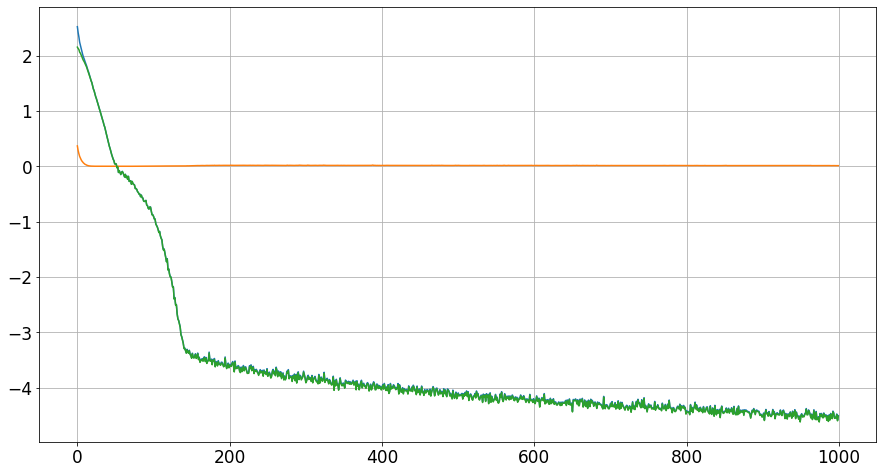

In [812]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(losses)
ax.plot(np.array(kl_loss))
ax.plot(-np.array(l_loss))
#ax.set_yscale("symlog")
#ax.set_xscale("log")

In [72]:
fig.savefig("./loss_sin_phase_pmamp.png")

In [813]:
run_data = MyDataset(100)
run_iterator = DataLoader(run_data, batch_size=100, shuffle=False)

In [814]:
samples = run(run_iterator,10000)

[0.01444727 0.12494358]
[0.01444727 0.12494358]


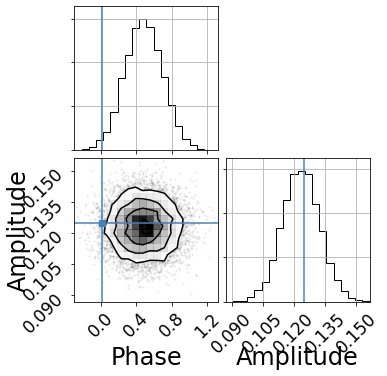

In [828]:
ind = 19
print(samples[1][ind])
print(run_data.data[ind][1])
fig = corner.corner(samples[0][ind],truths=samples[1][ind],labels=["Phase","Amplitude"])

In [825]:
out = test_mcmc(run_data.xs,run_data.data[ind][0],model=run_data.sin_model,inj=samples[1][ind])

/Users/josephbayley/.virtualenvs/soap/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/josephbayley/.virtualenvs/soap/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


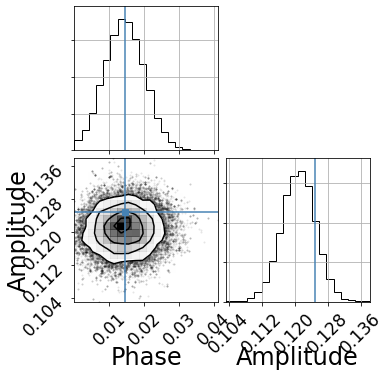

In [829]:
fig = corner.corner(out[:,:2],truths=samples[1][ind],labels=["Phase","Amplitude"])

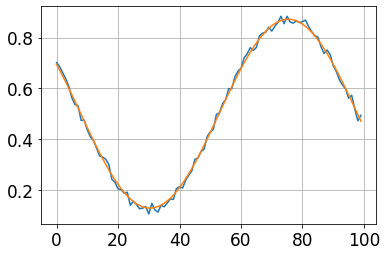

In [692]:
fig, ax = plt.subplots()
ax.plot(run_data.data[ind][0])
ax.plot(run_data.sin_model(run_data.xs, run_data.data[ind][1][0],run_data.data[ind][1][1]))
#ax.plot(run_data.sin_model(run_data.xs,*popt))

In [675]:
conf_levels = {"ph":[],"amp":[]}
sky_areas = []
inj_areas = []
parnames = ["ph","amp"]
num=0
for ind in range(len(samples[0])):
    
    for par in range(2):
        conf_level = sum(samples[0][ind].T[par] < samples[1][ind][par])/len(samples[0][ind].T[par])
        
        conf_levels[parnames[par]].append(conf_level)

In [676]:
cdfs = {}
for name in parnames:  
    cdfs[name] = lambda x: np.array([sum(conf_levels[name] < xx)/len(conf_levels[name]) for xx in x])

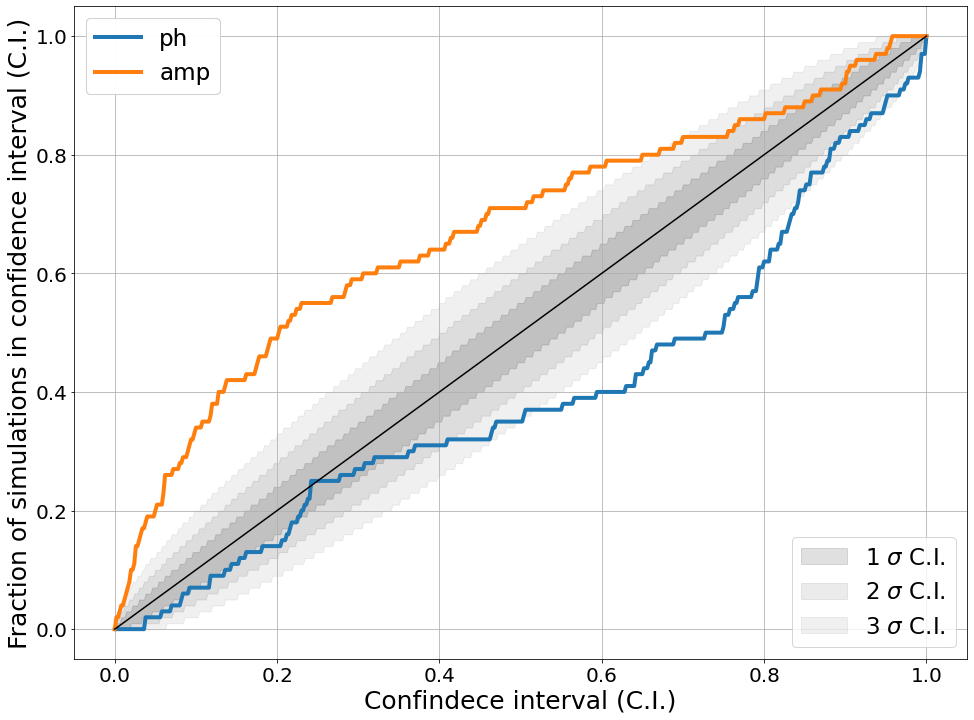

In [677]:
fig,ax = plt.subplots(figsize = (16,12))
fs = np.linspace(0,1.000001,501)
fanc_names = ["ph","amp"]
lines = []
for i,name in enumerate(parnames):
    ln = ax.plot(fs,cdfs[name](fs),label=fanc_names[i],lw=4)
    lines.append(ln[0])
    
confidence_interval=[0.68, 0.95, 0.997]
N = len(conf_levels["ph"])
cnames = [r"1 $\sigma$ C.I.",r"2 $\sigma$ C.I.",r"3 $\sigma$ C.I."]
alphas = [0.12,0.08,0.06]
areas = []
for i,ci in enumerate(confidence_interval):
    edge_of_bound = (1. - ci) / 2.
    lower = binom.ppf(1 - edge_of_bound, N, fs) / N
    upper = binom.ppf(edge_of_bound, N, fs) / N
    # The binomial point percent function doesn't always return 0 @ 0,
    # so set those bounds explicitly to be sure
    lower[0] = 0
    upper[0] = 0
    ar = ax.fill_between(fs, lower, upper, alpha=alphas[i], color='k',label=cnames[i])
    areas.append(ar)
ax.plot(fs,fs,"k")

leg1 = ax.legend(areas,cnames,fancybox=True,fontsize=23,loc="lower right")
leg2 = ax.legend(lines,fanc_names,fancybox=True,fontsize=23,loc="upper left")
ax.add_artist(leg1)
ax.add_artist(leg2)

ax.set_xlabel("Confindece interval (C.I.)",fontsize=25)
ax.set_ylabel("Fraction of simulations in confidence interval (C.I.)",fontsize=25)

ax.tick_params(axis='both', which='both', labelsize=20)
#ax.axvline(pars["f"],color="r")
ax.grid(True)

In [119]:
fig.savefig("./pp_sin_phase_pmamp.png")